In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as scs
import scipy.special as scl
import scipy.integrate as spint
import scipy.interpolate as spinterp
import scipy.fft as scft

The coincidence point on the detector plane is given by:
$$
y_{c} = \frac{-D sin \theta}{2 sin (\theta_b/2)}
$$
when ignoring the constant offset produced by the alignment of the mirrors.<br>
We, though, need to consider random path length variations as well (these can be caused by instabilities etc.):
$$
y_{c} = \frac{-D sin \theta}{2 sin (\theta_b/2)} + \Delta P
$$
We define a new variable $y'$ such that the fringes scale linearly with it:
$$
y' = y - y_c = y + \frac{D sin \theta}{2 sin (\theta_b/2)} - \Delta P
$$

We can now define our fringes using our new variable $y'$. We define fresnel inegration variable things:
$$
u = y'\sqrt{\frac{2}{\lambda L}}
$$
(I don't know yet how to define u_0 when we add the path length variation so for now I will just keep it the same)
$$
u_0 = \sqrt{2 N_f} = \frac{2W}{\lambda L}
$$
We can now use $u$ and $u_0$ to define our fringe pattern (wihtout the amplitude modification caused by the fresnel diffraction off the slats):
$$
A = 1 + exp(i\pi u u_0)
$$

In [2]:
def purefringes(y_detector, baseline_len, theta_offaxis, theta_b, beam_width, L, wavelength, delta_p=0, printvals = False):
    """
    This function calculates the fringe pattern for given parameters and detector y coordinates. 
    This function does not take into account the fresnel diffraction effect from the slats.
    """
    # y_0 is the central point of the fringes on the detector.
    y_0 = -baseline_len * np.sin(theta_offaxis) / (2 * np.sin(theta_b/2)) + delta_p
    # Re-define coordinate system such that y_prime is 0 for the central fringe
    y_prime = y_detector - y_0

    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    if printvals:
        
        # print(f'The expected fringe spacing is {fringe_spacing:.2e} m')
        # print(f'The expected centre of the fringes is at {y_0:.2e} m')
        pass

    return fringe_amp, fringe_spacing, y_0, y_prime

In [3]:
def fresnel_diff(y_detector, baseline_len, theta_offaxis, theta_b, beam_width, L, wavelength, delta_p=0, printvals = False):
    y_0 = -L * theta_offaxis
    y_prime = y_detector - y_0
    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    u_1 = u - u_0/2
    u_2 = u + u_0/2
    
    C_1, S_1 = scl.fresnel(u_1)
    # print('Integral',C_1)
    C_2, S_2 = scl.fresnel(u_2)

    # print(C_1, S_2)

    A = C_2 - C_1 + 1j*(S_2 - S_1)
    # plt.plot(np.abs(A)**2)
    # plt.show()
    

    if printvals:
        
        # print(f'The expected fringe spacing is {fringe_spacing:.2e} m')
        # print(f'The expected centre of the fringes is at {y_0:.2e} m')
        pass

    return A, y_prime, y_0

2.9999999999999997e-05


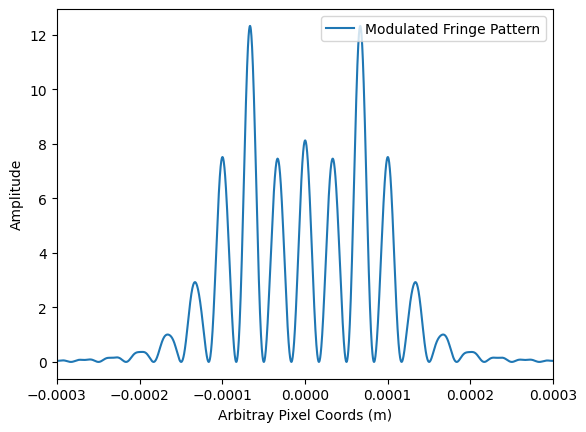

In [4]:
plt.close()

D = 1 # 1 Meter baseline
theta = 0 # Off axis angle

W = 300*1e-6 # 300 um
L = 10 # in m
theta_b = W / L
wavelength = 10 * 1e-10 # 10 A
delta_P = 300 * wavelength
print(theta_b)
y = np.linspace(-.0005, .0005, 5000)

# With off axis angle
A_pure, fringe_spacing, center_pure, y_prime = purefringes(y, D, theta, theta_b, W, L, wavelength, delta_P, printvals=True)
# plt.plot(y, np.abs(A_pure)**2,  label='Fringes')

A_fresnel, y_prime, center_f = fresnel_diff(y, D, theta, theta_b, W, L, wavelength, delta_P, printvals=True)
# plt.plot(y, np.abs(A_fresnel)**2, label=f'Fresnel Modulation')

# Without off axis angle
# theta_2 = 0
# A_pure_2, fringe_spacing_2, center_pure_2, y_prime_2 = purefringes(y, D, theta_2, theta_b, W, L, wavelength, delta_P, printvals=True)
# plt.plot(y, np.abs(A_pure_2)**2, label=f'fresnel pattern, theta: {theta_2}', linestyle='--')

# A_fresnel_2, y_prime_2, center_f_2 = fresnel_diff(y, D, theta_2, theta_b, W, L, wavelength, delta_P, printvals=True)
# plt.plot(y, np.abs(A_fresnel_2)**2, linestyle='--')

# print(center_pure, center_pure_2)
# print('Expected diff center:', center_pure_2 - center_pure)

plt.ylabel('Amplitude')
plt.xlabel('Arbitray Pixel Coords (m)')
# plt.legend()
# plt.close()
# plt.axvline(center, label='y_0', color='black', linestyle='--')
# plt.axvline(center_pure, label='y_0', color='black', linestyle='--')
# plt.axvline(center_pure_2, label='y_0', color='black', linestyle='--')

A_full = A_pure * A_fresnel
# A_full_2 = A_pure_2 * A_fresnel_2
plt.plot(y, np.abs(A_full)**2, label=f'Modulated Fringe Pattern')
# plt.plot(y, np.abs(A_full_2)**2, label=f'Full pattern for theta={theta_2}')
plt.xlim(-0.0003, 0.0003)
plt.legend()

We need to limit our fov such that the offset from center never gets to $\Delta y$

<h1>Sampling</h1>
<h2>Method 1: Sample from CDF</h2>
Here, I first convert our final fringe pattern into a pdf, then into a cdf and then sample from the cdf.

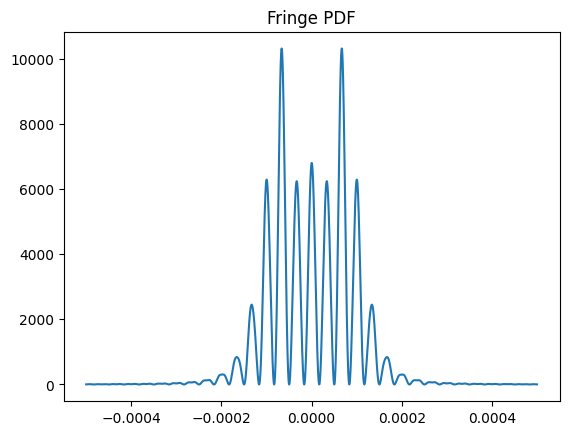

[-0.0004999 -0.0004997 -0.0004995 ...  0.0004995  0.0004997  0.0004999]
[-0.0004999 -0.0004997 -0.0004995 ...  0.0004995  0.0004997  0.0004999]


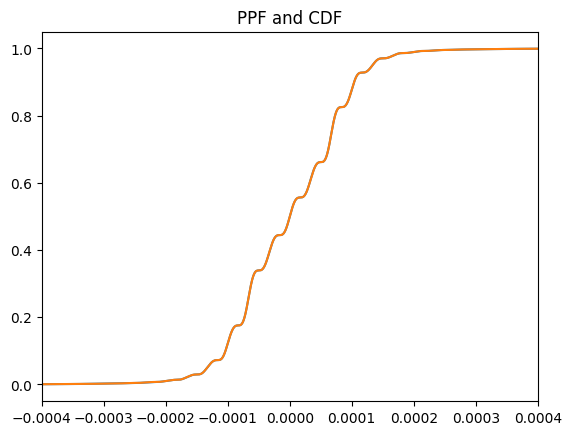

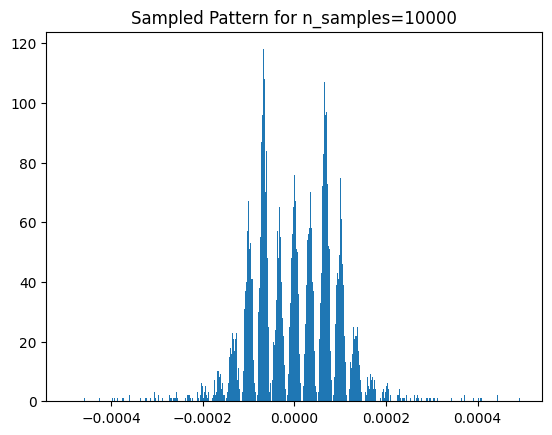

In [5]:
plt.close()
def conv_fringe_to_pdf(fringe_func, y):
    # Integrate over fringe function to find normalization factor
    norm = spint.trapezoid(fringe_func, y)
    # print('Norm factor:', norm)
    fringe_pdf = fringe_func/norm
    return fringe_pdf

fringe_pdf = conv_fringe_to_pdf(np.abs(A_full)**2, y)
plt.plot(y, fringe_pdf, label=f'Pdf for theta={theta*206265:.2e} arcsec')
plt.title('Fringe PDF')
plt.show()
def conv_to_cdf(input_pdf, y_range):
    cdf = spint.cumulative_trapezoid(input_pdf,y_range)
    y_centers = (y_range[:-1] + y_range[1:])/2
    
    
    # print(cdf.shape, y_range.shape)
    check = spint.trapezoid(cdf, y_centers)
    # print('Integral of cdf (should be 1):', check)
    return cdf, y_centers

fringe_cdf, y_centers = conv_to_cdf(fringe_pdf, y)
plt.plot(y_centers, fringe_cdf, label='CDF of fringe pattern')
# plt.show()

## Works till here

def sample_cdf(cdf, y, n_samples):
    samples = np.random.uniform(size=n_samples)
    ppf = spinterp.interp1d(cdf, y)
    # print(ppf(samples))
    plt.plot(ppf(np.linspace(0.00001,.999999,10000)),np.linspace(0.00001,.999999,10000))
    plt.title('PPF and CDF')
    plt.xlim(-4e-4, 4e-4)
    # plt.ylim
    plt.show()
    
    return ppf, ppf(samples)
print(y_centers)
print((y[1:] + y[:-1])/2)

n_samples = 10000
ppf, sampled = sample_cdf(fringe_cdf, y_centers, n_samples)
plt.title(f'Sampled Pattern for n_samples={n_samples}')
plt.hist(sampled, 1000)
plt.show()

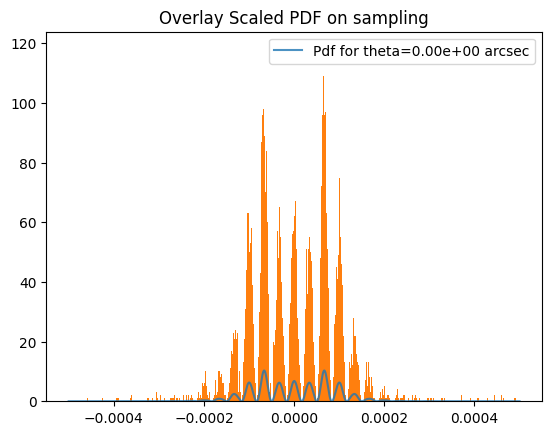

In [6]:
plt.plot(y, fringe_pdf/1e3, label=f'Pdf for theta={theta*206265:.2e} arcsec', alpha=0.8)
plt.title('Overlay Scaled PDF on sampling')
plt.hist(sampled, 1000)
plt.legend()
plt.show()

<H2>Accept Reject Sampling</H2>

2.9999999999999997e-05
Current Resolution of Detector (m) 2e-07
The maximum instensity is 12.328257949223184


(0.0, 12.328257949223184)

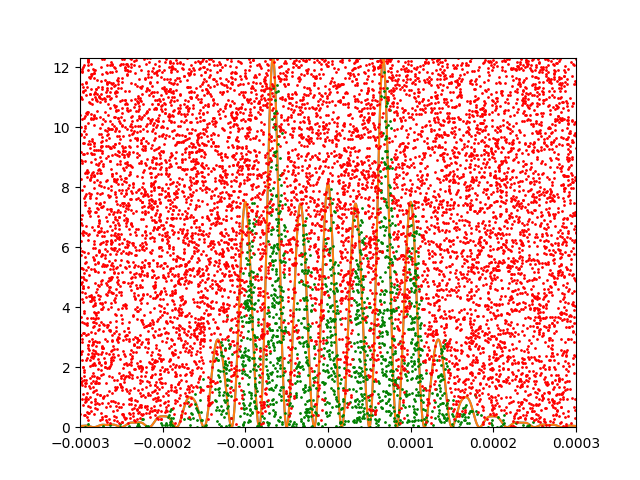

In [10]:
%matplotlib widget
plt.close()
D = 1 # 1 Meter baseline
theta = 0 # Off axis angle

W = 300*1e-6 # 300 um
L = 10 # in m
theta_b = W / L
wavelength = 10 * 1e-10 # 10 A
delta_P = 300 * wavelength
print(theta_b)
y = np.linspace(-.0005, .0005, 5000)
res = (.0005 + .0005)/5000
print('Current Resolution of Detector (m)', res)

def calc_single(y_val, baseline_len, theta_offaxis, theta_b, beam_width, L, wavelength, delta_p=0):
    """
    Calculates the amplitude for a single given y-axis position.
    """
    
    # Fringe Pattern
    y_0 = -baseline_len * np.sin(theta_offaxis) / (2 * np.sin(theta_b/2)) + delta_p
    y_prime = y_val - y_0

    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    A_fringe = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b
    
    
    # Fresnel Diffraction
    y_0 = -L * theta_offaxis
    y_prime = y_val - y_0
    # Define fresnel variables
    u = y_prime * np.sqrt(2/(wavelength * L))
    u_0 = beam_width * np.sqrt(2/(wavelength * L))

    # Define fringe amplitudes based on fresnel variables
    fringe_amp = 1 + np.exp(1j * u * u_0 * np.pi)
    fringe_spacing = wavelength/theta_b

    u_1 = u - u_0/2
    u_2 = u + u_0/2
    
    C_1, S_1 = scl.fresnel(u_1)
    # print('Integral',C_1)
    C_2, S_2 = scl.fresnel(u_2)

    # print(C_1, S_2)

    A_fresnel = C_2 - C_1 + 1j*(S_2 - S_1)

    A_full = A_fresnel * A_fringe
    return A_full

# A_full = calc_single(0.0006, D, theta, theta_b, W, L, wavelength, delta_P, printvals=True)
# Intensity = np.abs(A_pure)**2
# print(f'Testing single calc: {np.abs(A_full)**2:.2}')

# Figuring out maximum of the function
# Assuming that variations in path length and off axis angle only move the fringes around, we can calculate a constant maximum for theta=0 and delta_p = 0
theta = 0
delta_P = 0

A_pure, fringe_spacing, center_pure, y_prime = purefringes(y, D, theta, theta_b, W, L, wavelength, delta_P)
A_fresnel, y_prime, center_f = fresnel_diff(y, D, theta, theta_b, W, L, wavelength, delta_P)

A_full = A_pure * A_fresnel
I = np.abs(A_full)**2
I_max = np.max(I)

print(f'The maximum instensity is {I_max}')

plt.plot(y, I, label=f'Modulated Fringe Pattern')

delta_P = 10 * wavelength

# With off axis angle
A_pure, fringe_spacing, center_pure, y_prime = purefringes(y, D, theta, theta_b, W, L, wavelength, delta_P)
# plt.plot(y, np.abs(A_pure)**2,  label='Fringes')

A_fresnel, y_prime, center_f = fresnel_diff(y, D, theta, theta_b, W, L, wavelength, delta_P)
# plt.plot(y, np.abs(A_fresnel)**2, label=f'Fresnel Modulation')

A_full = A_pure * A_fresnel

I = np.abs(A_full)**2
# I_max = np.max(I)
# print(f'The maximum instensity is {I_max}')
plt.plot(y, I, label=f'Modulated Fringe Pattern')
size_samples = 10000
y_detector_max = 0.0003
y_sample = np.random.uniform(size = size_samples) * y_detector_max * 2 - y_detector_max
I_sample = np.random.uniform(size = size_samples) * I_max
temp = []

for i in range(1):
    delta_P = np.random.uniform(size = size_samples) * 10000 * wavelength
    y_sample = np.random.uniform(size = size_samples) * y_detector_max * 2 - y_detector_max
    I_sample = np.random.uniform(size = size_samples) * I_max
    I_true = np.abs(calc_single(y_sample, D, theta, theta_b, W, L, wavelength, delta_P))**2
    accepted_y, accepted_I = y_sample[I_sample <= I_true], I_sample[I_sample <= I_true]
    rejected_y, rejected_I = y_sample[I_sample > I_true], I_sample[I_sample > I_true]
    plt.plot(accepted_y, accepted_I, '.', color='green', markersize=2)
    plt.plot(rejected_y, rejected_I, '.', color='red', markersize=2)
    # if I_sample < I_true:
    #     temp.append([y_sample, I_sample])
    #     plt.plot(y_sample, I_sample, '.', color='green', markersize=2)
    # else:
    #     plt.plot(y_sample, I_sample, '.', color='red', markersize=2)
plt.xlim(-0.0003, 0.0003)
plt.ylim(0, I_max)
# I_actual = calc_single(y_sample, D, theta, theta_b, W, L, wavelength, delta_P, printvals=True)**2
# temp = np.array(temp)
# plt.plot(temp[:,0], temp[:,1], '.')



    
    

0.26310471138057345


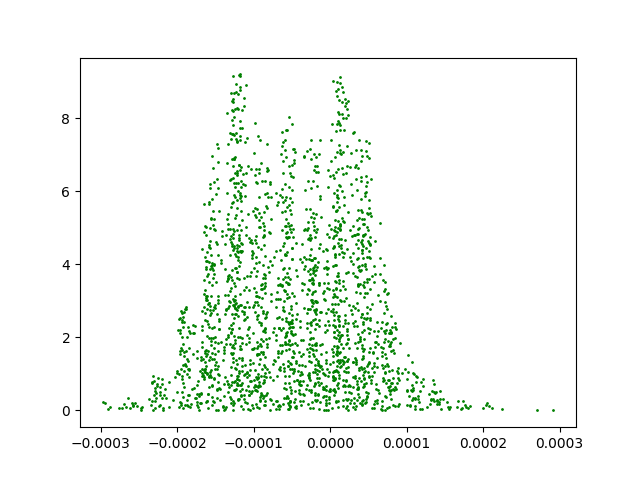

In [16]:
plt.close()
def GenerateSingleSample(sample_size, ret_ph_count = False):
    D = 1 # 1 Meter baseline
    W = 300*1e-6 # 300 um
    L = 10 # in m
    theta_b = W / L
    wavelength = 10 * 1e-10 # 10 A
    # print(theta_b)
    y_detector_max = 0.0003
    y = np.linspace(-y_detector_max, y_detector_max, 5000)
    res = (.0005 + .0005)/5000
    # print('Current Resolution of Detector (m)', res)

    # Calculate Max of I based on max at theta=0, delta_P = 0
    delta_P = 0
    theta =5e-6 # Off axis angle
    A_pure, fringe_spacing, center_pure, y_prime = purefringes(y, D, theta, theta_b, W, L, wavelength, delta_P)
    A_fresnel, y_prime, center_f = fresnel_diff(y, D, theta, theta_b, W, L, wavelength, delta_P)
    
    A_full = A_pure * A_fresnel
    I = np.abs(A_full)**2
    I_max = np.max(I)
    
    # print(f'The maximum instensity is {I_max}')

    
    # Sampling
    
    size_samples = sample_size # The number of samples taken per readout

    # Sample y pixel coord and I value using y_max and I_max resepctively
    y_sample = np.random.uniform(size = size_samples) * y_detector_max * 2 - y_detector_max
    I_sample = np.random.uniform(size = size_samples) * I_max


    
    
    # delta_P = np.random.uniform(size = size_samples) * 1e4 * wavelength # Re-define variation here later!
    delta_P = np.random.uniform(size = size_samples) * 2e-5
    y_sample = np.random.uniform(size = size_samples) * y_detector_max * 2 - y_detector_max
    I_sample = np.random.uniform(size = size_samples) * I_max
    
    # Calculate 'true' values of each sampled y pixel based on random delta_P and other parameters
    I_true = np.abs(calc_single(y_sample, D, theta, theta_b, W, L, wavelength, delta_P))**2

    # Compare sampled I value with true value to accept/reject
    accepted_y, accepted_I = y_sample[I_sample <= I_true], I_sample[I_sample <= I_true]
    rejected_y, rejected_I = y_sample[I_sample > I_true], I_sample[I_sample > I_true]

    # print(f'There were {len(accepted_y)} photons detected')
    n_accepted = len(accepted_y)
    if not ret_ph_count:
        return accepted_y, accepted_I, rejected_y, rejected_I
    else:
        return accepted_y, accepted_I, rejected_y, rejected_I, n_accepted

accepted_y, accepted_I, rejected_y, rejected_I = GenerateSingleSample(10000)
print(len(accepted_y)/len(rejected_y))
plt.plot(accepted_y, accepted_I, '.', color='green', markersize=2)
# plt.plot(rejected_y, rejected_I, '.', color='red', markersize=2)
plt.show()

Res: 1.00e-06


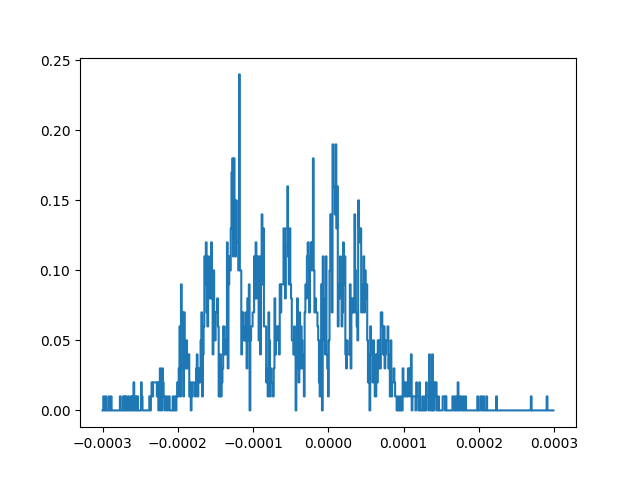

In [17]:
plt.close()
# Bin the accepted samples
n_bins = 600
spacing = (2 * 0.0003) / n_bins
print(f'Res: {spacing:.2e}')
bins_y = np.linspace(-0.0003, -.0003 + spacing * n_bins, n_bins, endpoint=True)
# print(bins_y)
counts, edges = np.histogram(accepted_y, bins=bins_y)
plt.step(edges[:-1], counts/100)
plt.show()

0.001669449081803005 0.0008347245409015025
0.0 -1666.666666666636
29999.999999999447


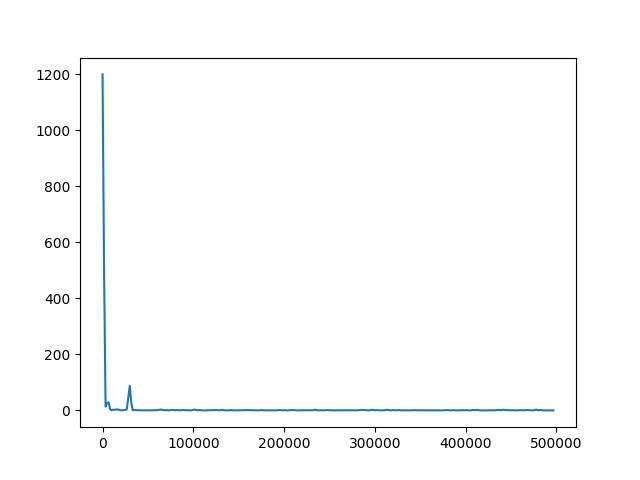

In [18]:
plt.close()
# Define Fourier Frequencies:
N = len(edges) - 1 # Number of bins
min_freq = 1/N
max_freq = 1/2 * (1/N)
print(min_freq, max_freq)

# Take the Fourier Transform
yf = scft.fft(counts)
pf_norm = 2 * n_bins * np.abs(yf)**2 / (np.sum(counts)**2)
# pf_norm = np.abs(yf)**2

# Define the corresponding frequencies
xf = scft.fftfreq(N, edges[1]-edges[0])

peak_freq = xf[np.argsort(np.abs(yf)**2)[-4]]
print(xf[0], xf[-1])
print(peak_freq)

plt.plot(xf[:N//2], pf_norm[:N//2])
# plt.xlim(-.3e6, .3e6)
plt.show()

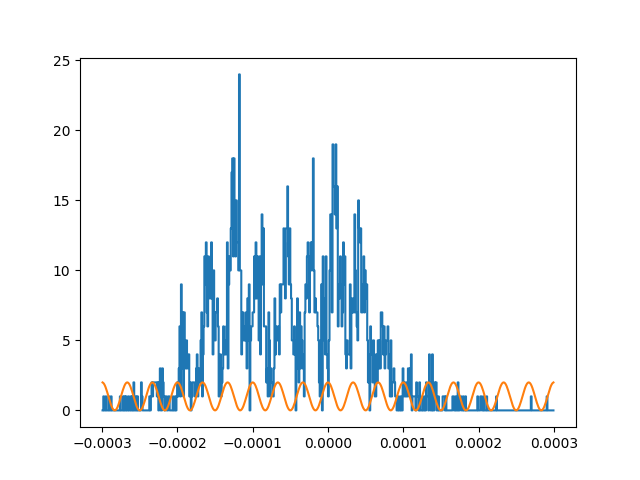

In [19]:
plt.close()
centres = (edges[:-1] + edges[1:])/2
plt.step(centres, counts)
plt.plot(centres, 1 +  np.cos(peak_freq * centres * 2 * np.pi))
plt.show()

1. Loop until a certain number of counts are accepted - based on like the expected number of photons per second
2. Efficiency: Generate a bunch of random path length variations and compute all at once?
3. Define some 'extent' that chooses which slat we are in
4. How does max vary w/ $\lambda$
5. Range of wavelengths - ask on Thursday

<h2>Stacking Periodograms</h2>

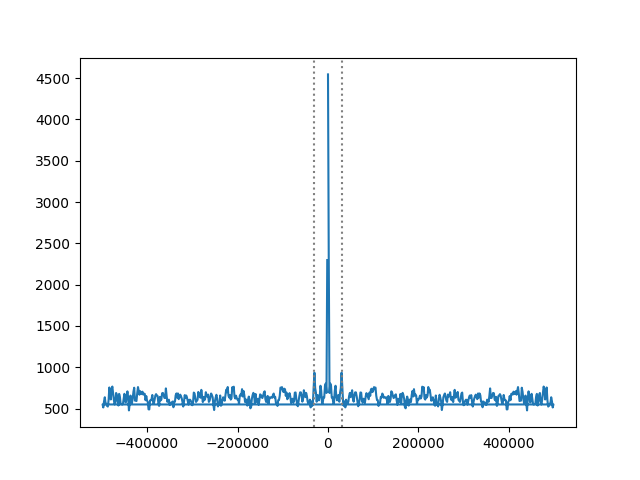

In [20]:
plt.close()
yf_list = []
accepted_photons = []
for i in range(100):
    
    accepted_y, accepted_I, rejected_y, rejected_I, n_ph = GenerateSingleSample(30, True)
    accepted_photons.append(n_ph)
    n_bins = 600
    spacing = (2 * 0.0003) / n_bins
    bins_y = np.linspace(-0.0003, -.0003 + spacing * n_bins, n_bins, endpoint=True)
    counts, edges = np.histogram(accepted_y, bins=bins_y)
    
    # plt.step(edges[:-1], counts/100)
    # plt.show()
    
    # if np.sum(counts>0):
        # Define Fourier Frequencies:
    N = len(edges) - 1 # Number of bins
    min_freq = 1/N
    max_freq = 1/2 * (1/N)
    # print(min_freq, max_freq)
    
    # Take the Fourier Transform
    yf = scft.fft(counts)
    
    # Normalize
    # yf = 2 * n_bins * np.abs(yf)**2 / (np.sum(counts)**2)
    yf = np.abs(yf)**2
    yf_list.append(yf)
    
    # Define the corresponding frequencies
    xf = scft.fftfreq(N, edges[1]-edges[0])

    
    # peak_freq = xf[np.argsort(np.abs(yf)**2)[-4]]
    # print(xf[0], xf[-1])
    # print(peak_freq)
    # plt.plot(xf)
yf_list = np.array(yf_list)
sum_yf = np.sum(yf_list, axis=0)
P_noise = 2 * n_bins / np.sum(accepted_photons)
Prob = 1 - np.exp(-yf_list / P_noise)
# print(accepted_photons)
plt.plot(xf, sum_yf)
plt.axvline(30000, linestyle='dotted', color='grey')
plt.axvline(-30000, linestyle='dotted', color='grey')
plt.show()

In [8]:
plt.close()
plt.hist(accepted_photons, bins=30)
plt.show()

NameError: name 'accepted_photons' is not defined